# Predicting Academic Dropout or Success in Higher Education


This project aims to predict student dropout rates in higher education using supervised learning. By analyzing factors like demographics, socio-economic status, and academic path, we hope to provide insights for early interventions. The beneficiaries are educational institutions, advisors, and students who gain from improved resource allocation and personalized support.

The Dataset used :
Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís. (2021). Predict Students' Dropout and Academic Success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.

UC Irvine Machine Learning Repo :
https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

Connecting to the google drive to retreive the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/CIS_412_Team18_Project/data.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#

## Importing Essential modules

In [2]:
#import data libraries
import pandas as pd
import numpy as np

#import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder # for encoding categorical features from strings to number arrays
from sklearn.naive_bayes import MultinomialNB, CategoricalNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Read and quick look at the data

In [3]:
# Read the cvs and convert into pandas Dataframe
df = pd.read_csv(path, delimiter=";")
pd.set_option('display.max_rows', 1000)
# Check the shape and content
print(df.shape)
display(df.head())
print(df.dtypes)


(4424, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance\t                        int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

In [4]:
df = df.rename(columns={'Nacionality': 'Nationality'})

missingValues = df.isnull().sum().sum()
print(f'There are total of {missingValues} mising values in the dataset.')

There are total of 0 mising values in the dataset.


## Exploratory Data Analysis

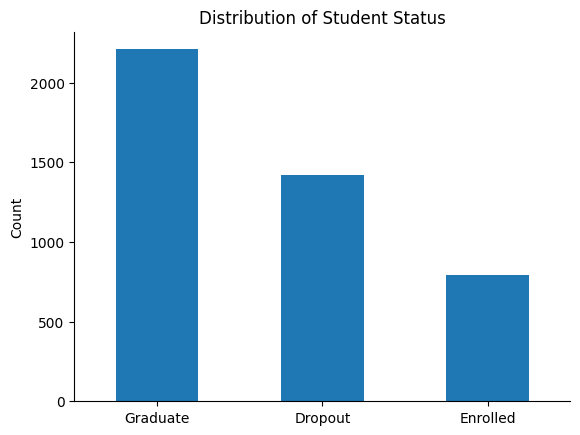

In [5]:
target = df['Target']

target.value_counts().plot(kind='bar')
sns.despine()
plt.ylabel('Count')
plt.title('Distribution of Student Status')
plt.xticks(rotation=0)
plt.show()


In [6]:
print(f"Graduate count: {target.value_counts()['Graduate']}")
print(f"Dropout count: {target.value_counts()['Dropout']}")
print(f"Enrolled count: {target.value_counts()['Enrolled']}")


Graduate count: 2209
Dropout count: 1421
Enrolled count: 794


Our research focuses on the predicting if the student have the potential to dropout out or will he succeed. The ‘Enrolled’ status represents students who are currently in the process of completing their studies. Since their final status (graduate or dropout) is undetermined, including them in the analysis could lead to inaccurate predictions. So we remove the enrolled students.

In [7]:
df = df[df['Target'] != 'Enrolled']
df['Target'].value_counts()


Graduate    2209
Dropout     1421
Name: Target, dtype: int64

In [8]:
#@title Create mapping dictionaries
marital_status_dict = {
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto Union',
    6: 'Legally Separated'
}

application_mode_dict = {
    1: '1st phase - general contingent',
    2: 'Ordinance No. 612/93',
    5: '1st phase - special contingent (Azores Island)',
    7: 'Holders of other higher courses',
    10: 'Ordinance No. 854-B/99',
    15: 'International student (bachelor)',
    16: '1st phase - special contingent (Madeira Island)',
    17: '2nd phase - general contingent',
    18: '3rd phase - general contingent',
    26: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
    27: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
    39: 'Over 23 years old',
    42: 'Transfer',
    43: 'Change of course',
    44: 'Technological specialization diploma holders',
    51: 'Change of institution/course',
    53: 'Short cycle diploma holders',
    57: 'Change of institution/course (International)'
}

application_order_dict = {
    0: 'first choice',
    1: 'first choice',
    2: 'first choice',
    3: 'first choice',
    4: 'first choice',
    5: 'first choice',
    6: 'first choice',
    7: 'first choice',
    8: 'first choice',
    9: 'second choice'

}

course_dict = {
    33: 'Biofuel Production Technologies',
    171: 'Animation and Multimedia Design',
    8014: 'Social Service (evening attendance)',
    9003: 'Agronomy',
    9070: 'Communication Design',
    9085: 'Veterinary Nursing',
    9119: 'Informatics Engineering',
    9130: 'Equinculture',
    9147: 'Management',
    9238: 'Social Service',
    9254: 'Tourism',
    9500: 'Nursing',
    9556: 'Oral Hygiene',
    9670: 'Advertising and Marketing Management',
    9773: 'Journalism and Communication',
    9853: 'Basic Education',
    9991: 'Management (evening attendance)'
}

daytime_evening_attendance_dict = {
    1: 'daytime',
    0: 'evening'
}

previous_qualification_dict = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: 'Higher Education - Bachelor\'s Degree',
    3: 'Higher Education - Degree',
    4: 'Higher Education - Master\'s',
    5: 'Higher Education - Doctorate',
    6: 'Frequency of Higher Education',
    9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed',
    11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling',
    14: '10th Year of Schooling',
    15: '10th Year of Schooling - Not Completed',
    18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    22: 'Technical-professional course',
    26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed',
    30: '8th year of schooling',
    34: 'Unknown',
    35: 'Can\'t read or write',
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course',
    43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)'
}


profession_dict = {
    0: 'Student',
    1: 'Legislative & Executive Representatives, Directors',
    2: 'Intellectual & Scientific Specialists',
    3: 'Intermediate Technicians',
    4: 'Administrative Staff',
    5: 'Personal Services, Security & Sellers',
    6: 'Agriculture, Fisheries & Forestry Workers',
    7: 'Industry, Construction & Craftsmen',
    8: 'Machine Operators & Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces',
    90: 'Other',
    99: '(blank)',
    101: 'Armed Forces Officers',
    102: 'Armed Forces Sergeants',
    103: 'Other Armed Forces',
    112: 'Admin & Commercial Directors',
    114: 'Hotel, Catering & Trade Directors',
    121: 'Physical Sciences & Engineering Specialists',
    122: 'Health Professionals',
    123: 'Teachers',
    124: 'Finance & Accounting Specialists',
    131: 'Intermediate Science & Engineering Technicians',
    132: 'Intermediate Health Technicians',
    134: 'Intermediate Legal, Social & Cultural Technicians',
    135: 'ICT Technicians',
    141: 'Office Workers & Secretaries',
    143: 'Data & Accounting Operators',
    144: 'Other Admin Support',
    151: 'Personal Service Workers',
    152: 'Sellers',
    153: 'Personal Care Workers',
    154: 'Security Personnel',
    161: 'Market-Oriented Farmers & Skilled Workers',
    163: 'Subsistence Farmers & Fishermen',
    171: 'Skilled Construction Workers',
    172: 'Metallurgy & Metalworking Workers',
    174: 'Electricity & Electronics Workers',
    175: 'Food Processing & Woodworking Workers',
    181: 'Fixed Plant Operators',
    182: 'Assembly Workers',
    183: 'Vehicle Drivers',
    192: 'Unskilled Agriculture & Animal Production Workers',
    193: 'Unskilled Industry & Construction Workers',
    194: 'Meal Preparation Assistants',
    195: 'Street Vendors & Service Providers'
}


displaced_dict = {
    1: 'yes',
    0: 'no'
}

educational_special_needs_dict = {
    1: 'yes',
    0: 'no'
}

debtor_dict = {
    1: 'yes',
    0: 'no'
}

tuition_fees_up_to_date_dict = {
    1: 'yes',
    0: 'no'
}

gender_dict = {
    1: 'male',
    0: 'female'
}

scholarship_holder_dict = {
    1: 'yes',
    0: 'no'
}

country_code_dict = {
    1: 'Portugal',
    2: 'Germany',
    6: 'Spain',
    11: 'Italy',
    13: 'Netherlands',
    14: 'United Kingdom',
    17: 'Lithuania',
    21: 'Angola',
    22: 'Cape Verde',
    24: 'Guinea',
    25: 'Mozambique',
    26: 'Sao Tome and Principe',
    32: 'Turkey',
    41: 'Brazil',
    62: 'Romania',
    100: 'Moldova',
    101: 'Mexico',
    103: 'Ukraine',
    105: 'Russia',
    108: 'Cuba',
    109: 'Colombia'
}

country_to_continent = {
    'Portugal': 'Europe',
    'Germany': 'Europe',
    'Spain': 'Europe',
    'Italy': 'Europe',
    'Netherlands': 'Europe',
    'United Kingdom': 'Europe',
    'Lithuania': 'Europe',
    'Angola': 'Africa',
    'Cape Verde': 'Africa',
    'Guinea': 'Africa',
    'Mozambique': 'Africa',
    'Sao Tome and Principe': 'Africa',
    'Turkey': 'Europe',
    'Brazil': 'South America',
    'Romania': 'Europe',
    'Moldova': 'Europe',
    'Mexico': 'North America',
    'Ukraine': 'Europe',
    'Russia': 'Europe',
    'Cuba': 'North America',
    'Colombia': 'South America'
}

international_dict = {
    1: 'yes',
    0: 'no'
}




In [9]:
#@title Create a new DataFrame with names instead of numbers
df_withnames = df.copy()
df_withnames['Marital status'] = df_withnames['Marital status'].replace(marital_status_dict)
df_withnames['Application mode'] = df_withnames['Application mode'].replace(application_mode_dict)
df_withnames['Application order'] = df_withnames['Application order'].replace(application_order_dict)
df_withnames['Course'] = df_withnames['Course'].replace(course_dict)
df_withnames['Daytime/evening attendance\t'] = df_withnames['Daytime/evening attendance\t'].replace(daytime_evening_attendance_dict)
df_withnames['Previous qualification'] = df_withnames['Previous qualification'].replace(previous_qualification_dict)
df_withnames["Mother's qualification"] = df_withnames["Mother's qualification"].replace(previous_qualification_dict)
df_withnames["Father's qualification"] = df_withnames["Father's qualification"].replace(previous_qualification_dict)
df_withnames["Mother's occupation"] = df_withnames["Mother's occupation"].replace(profession_dict)
df_withnames["Father's occupation"] = df_withnames["Father's occupation"].replace(profession_dict)
df_withnames['Displaced'] = df_withnames['Displaced'].replace(displaced_dict)
df_withnames['Educational special needs'] = df_withnames['Educational special needs'].replace(educational_special_needs_dict)
df_withnames['Debtor'] = df_withnames['Debtor'].replace(debtor_dict)
df_withnames['Tuition fees up to date'] = df_withnames['Tuition fees up to date'].replace(tuition_fees_up_to_date_dict)
df_withnames['Gender'] = df_withnames['Gender'].replace(gender_dict)
df_withnames['Scholarship holder'] = df_withnames['Scholarship holder'].replace(scholarship_holder_dict)
df_withnames['International'] = df_withnames['International'].replace(international_dict)

In [10]:
print(df_withnames.dtypes)

Marital status                                     object
Application mode                                   object
Application order                                  object
Course                                             object
Daytime/evening attendance\t                       object
Previous qualification                             object
Previous qualification (grade)                    float64
Nationality                                         int64
Mother's qualification                             object
Father's qualification                             object
Mother's occupation                                object
Father's occupation                                object
Admission grade                                   float64
Displaced                                          object
Educational special needs                          object
Debtor                                             object
Tuition fees up to date                            object
Gender        

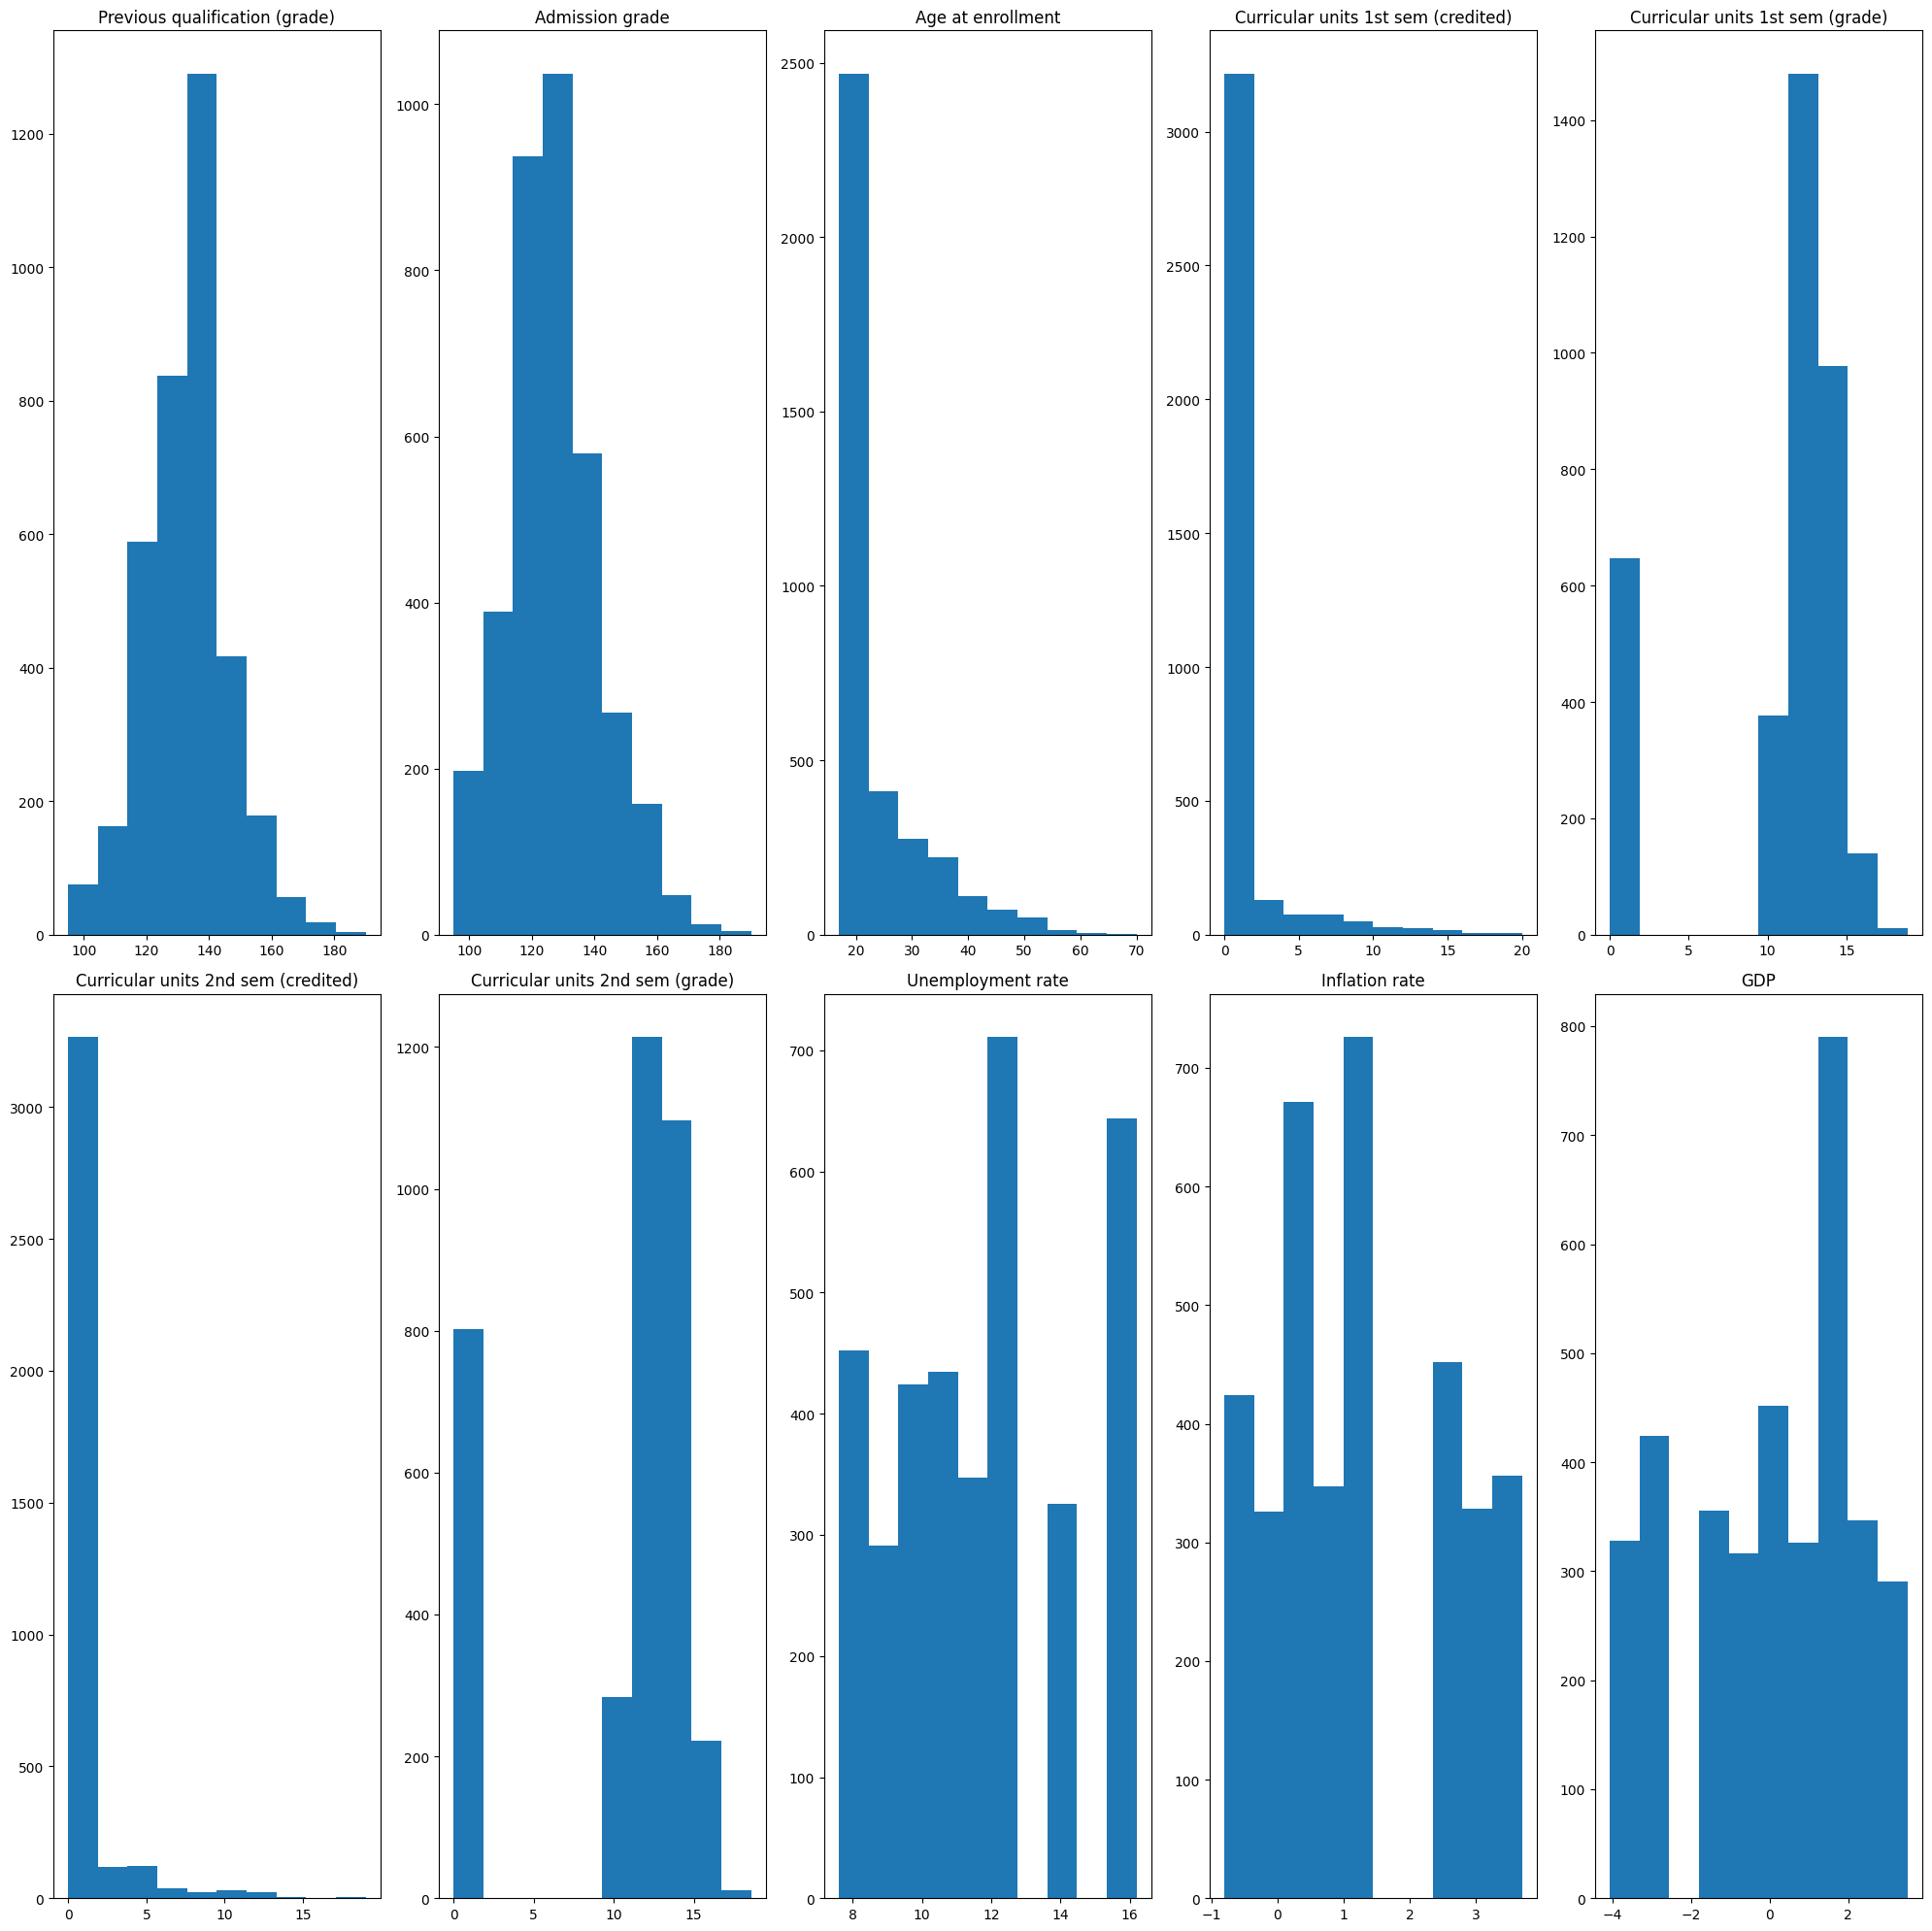

In [11]:
import matplotlib.pyplot as plt

# List of numerical features
numerical_features = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
                      'Curricular units 1st sem (credited)', 'Curricular units 1st sem (grade)',
                      'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (grade)',
                      'Unemployment rate', 'Inflation rate', 'GDP']

# Create a figure for the subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 20))

# Create a histogram for each numerical feature
for i, feature in enumerate(numerical_features):
    row = i // 5
    col = i % 5
    axs[row, col].hist(df[feature])
    axs[row, col].set_title(feature)

# Adjust the layout
plt.tight_layout()
plt.show()


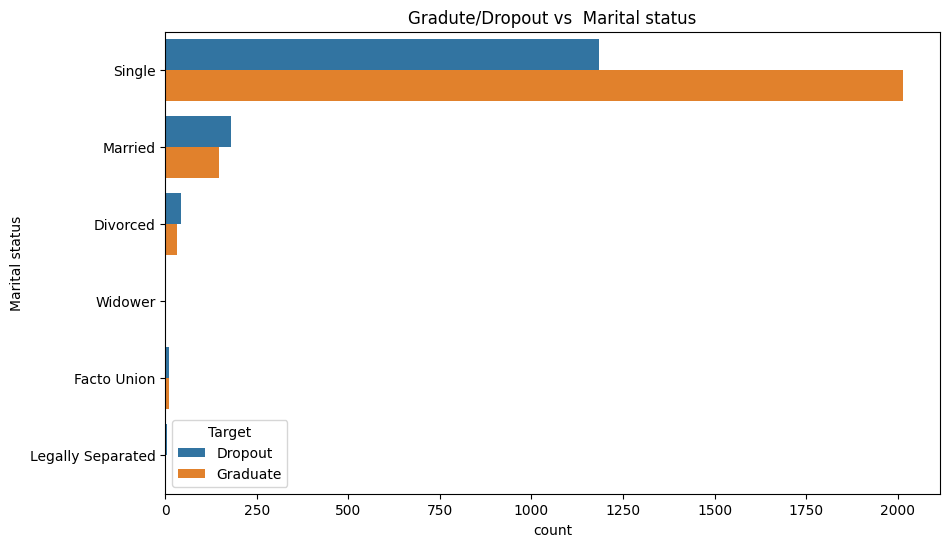

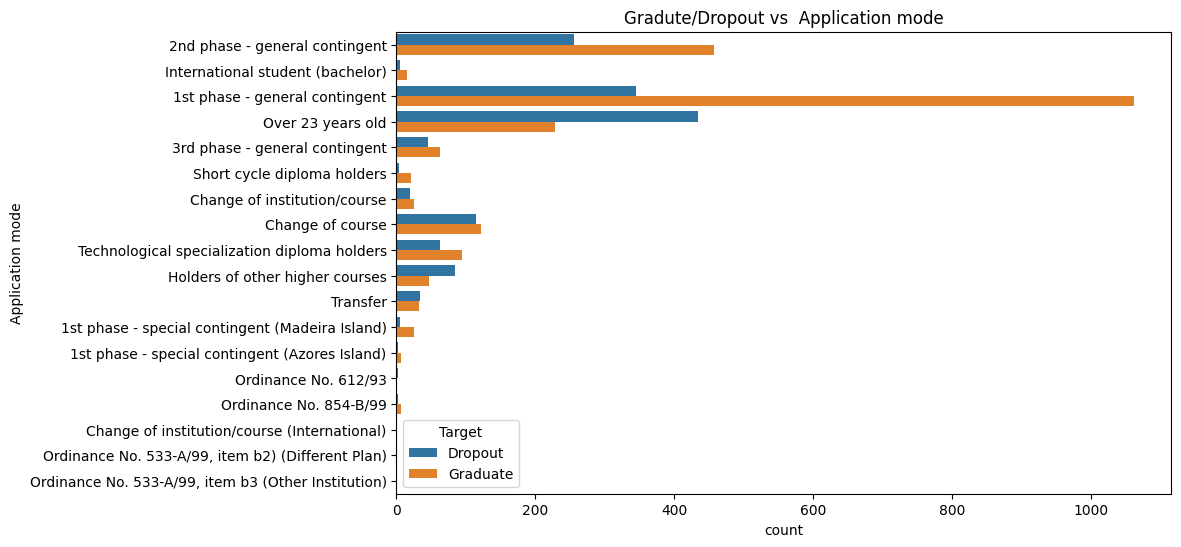

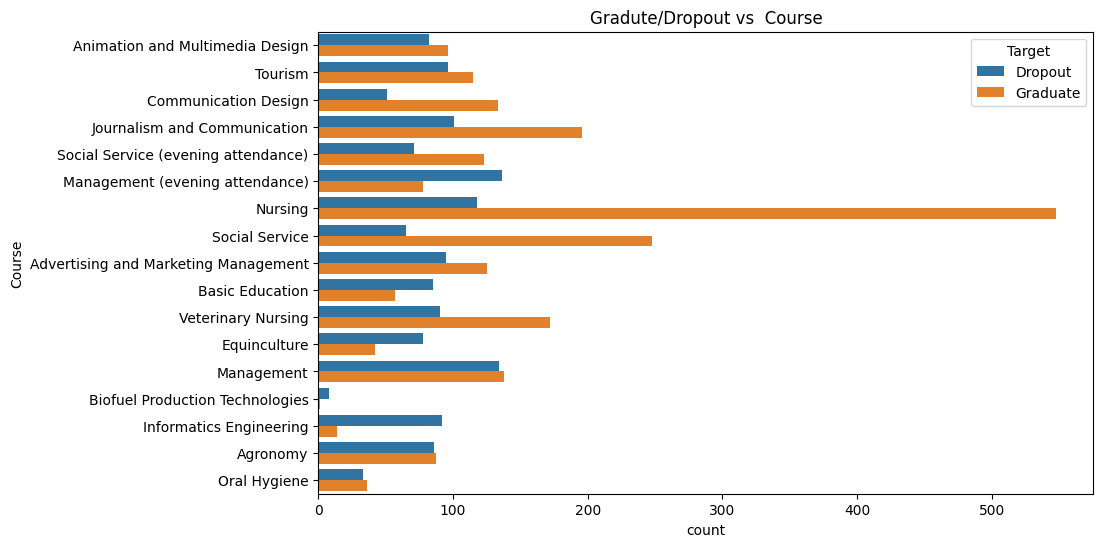

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


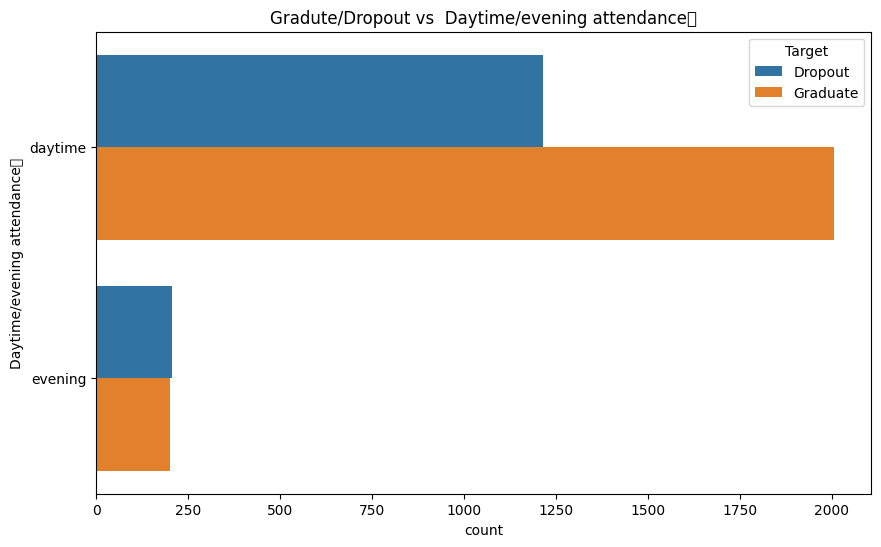

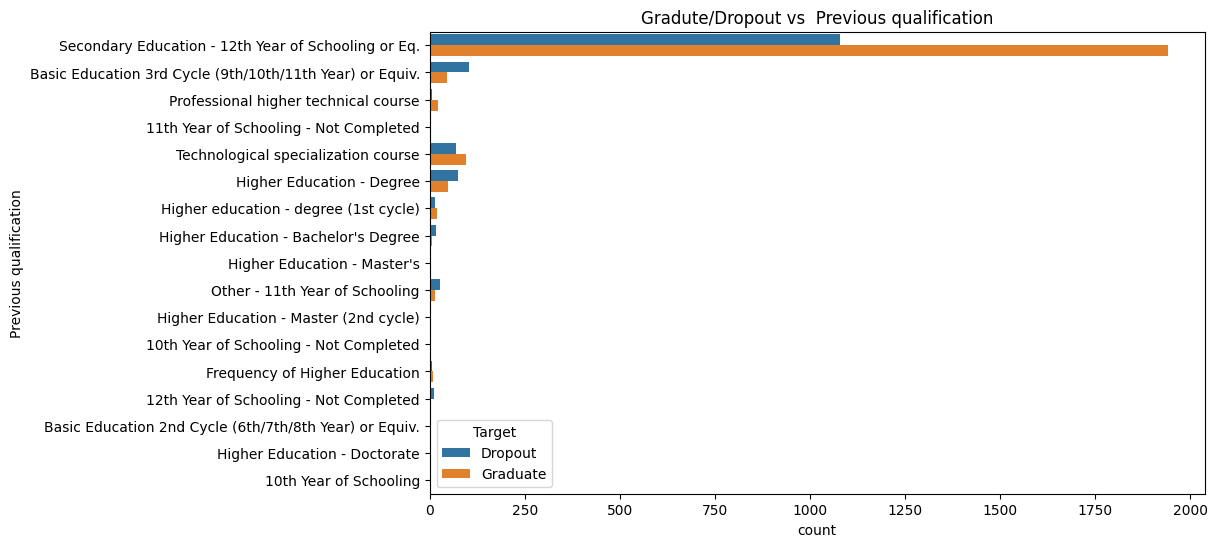

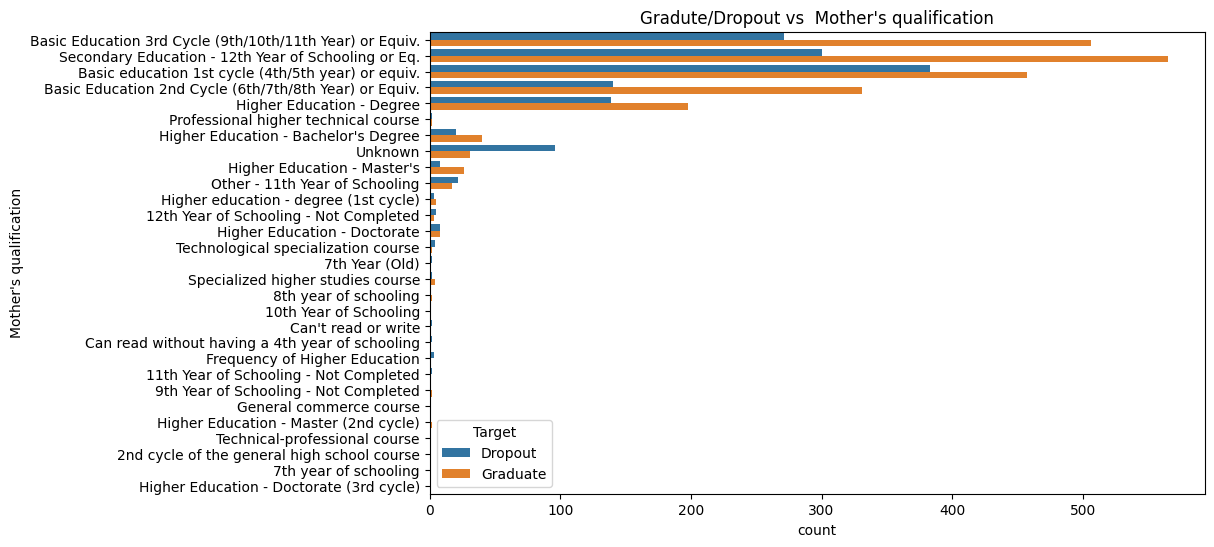

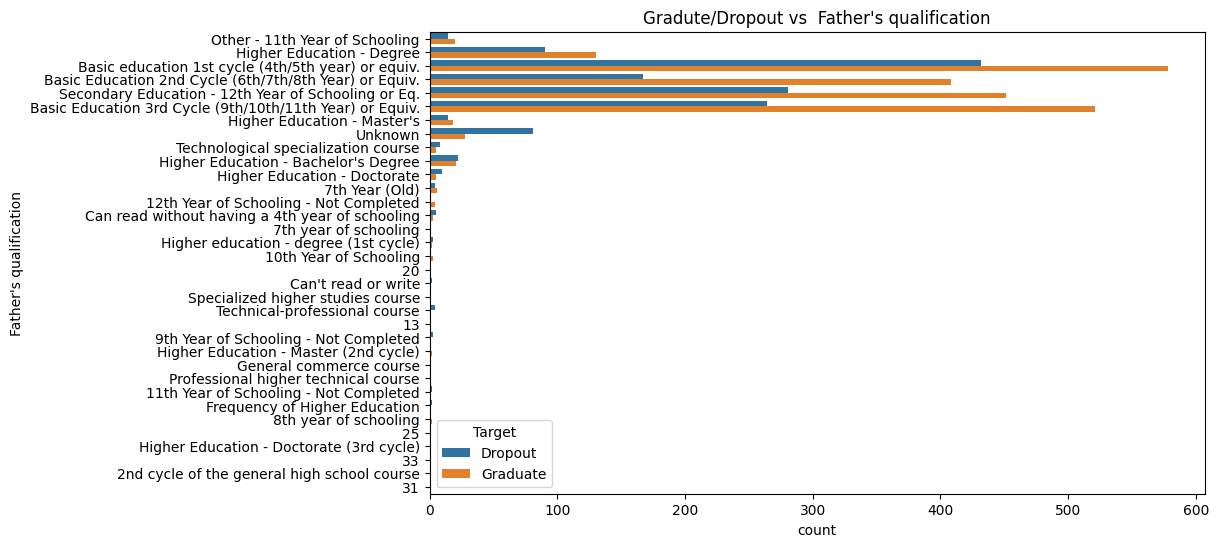

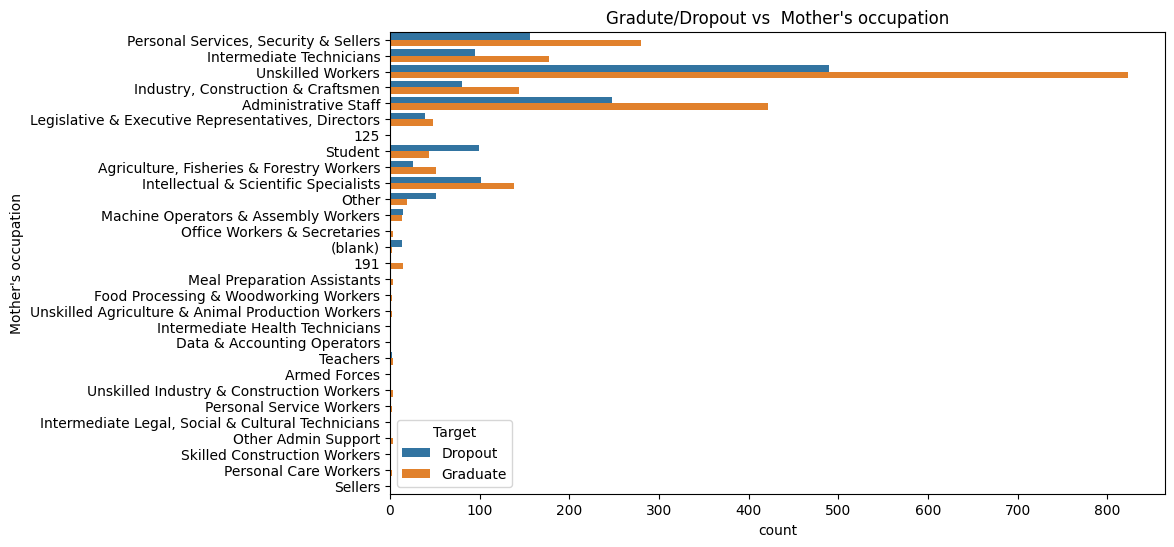

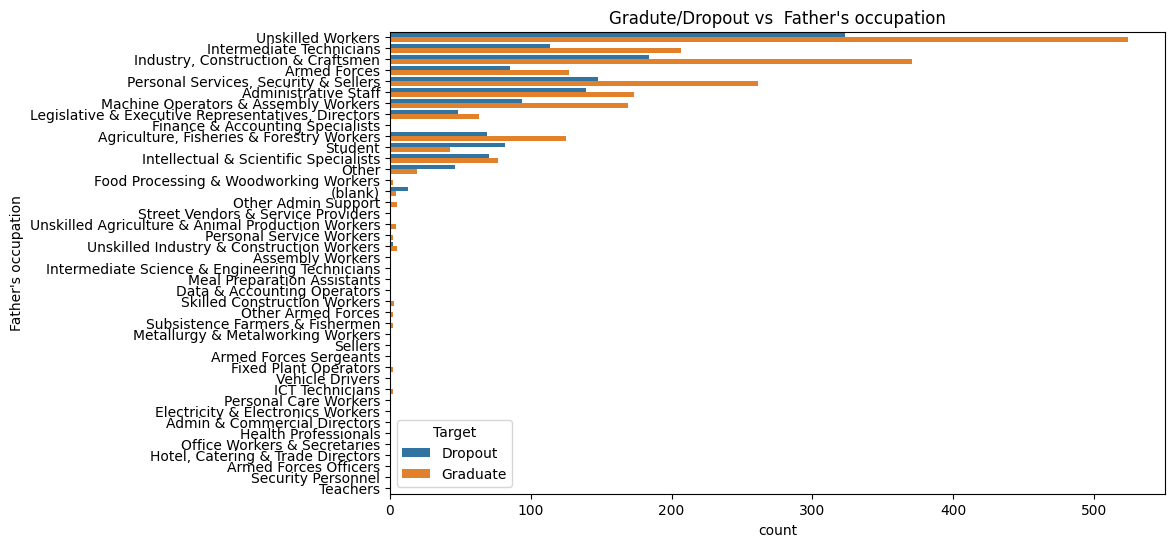

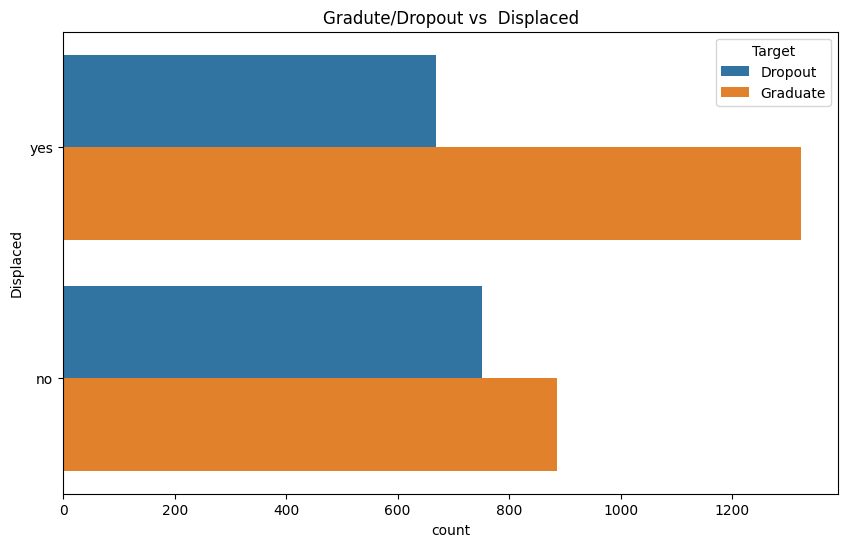

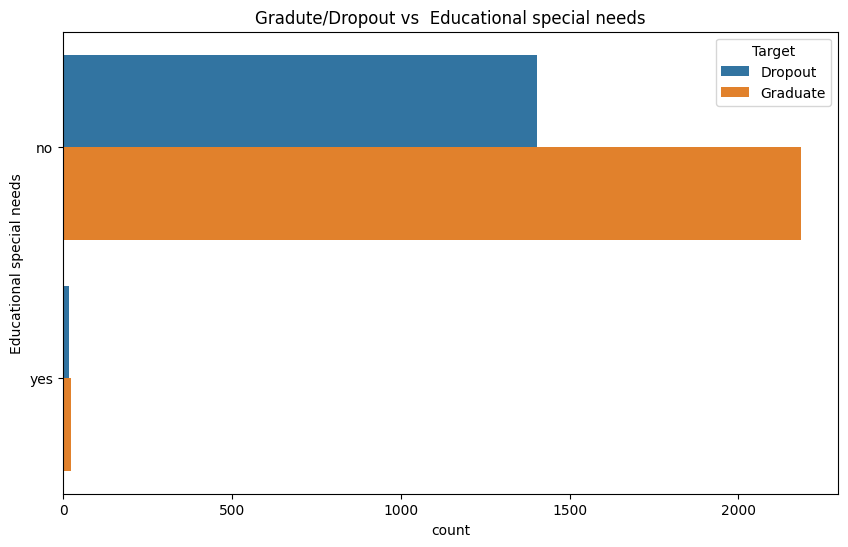

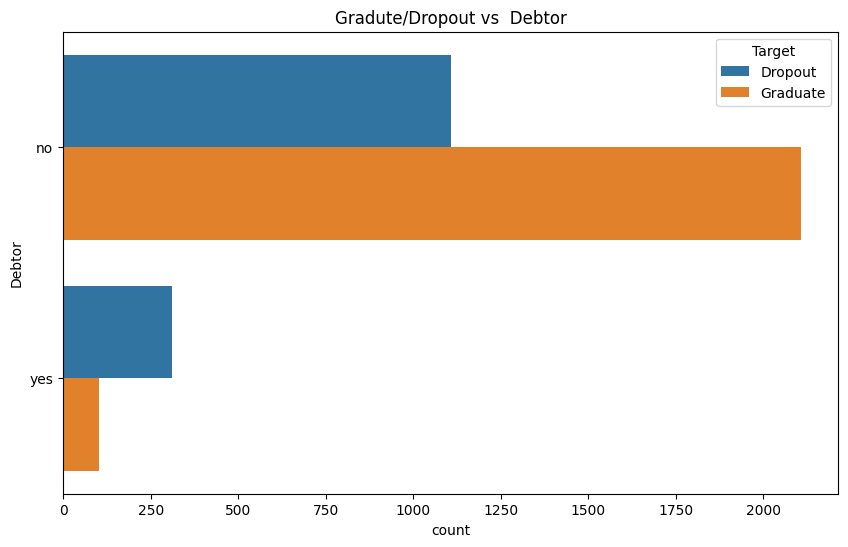

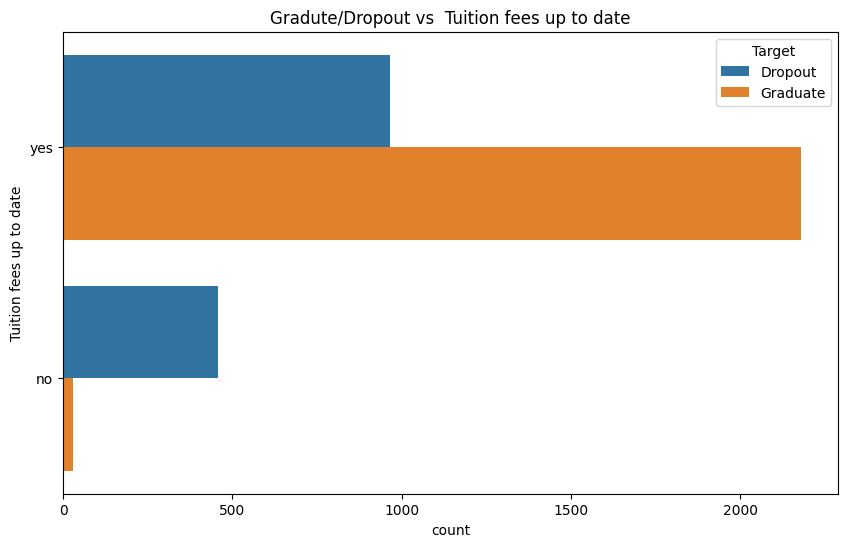

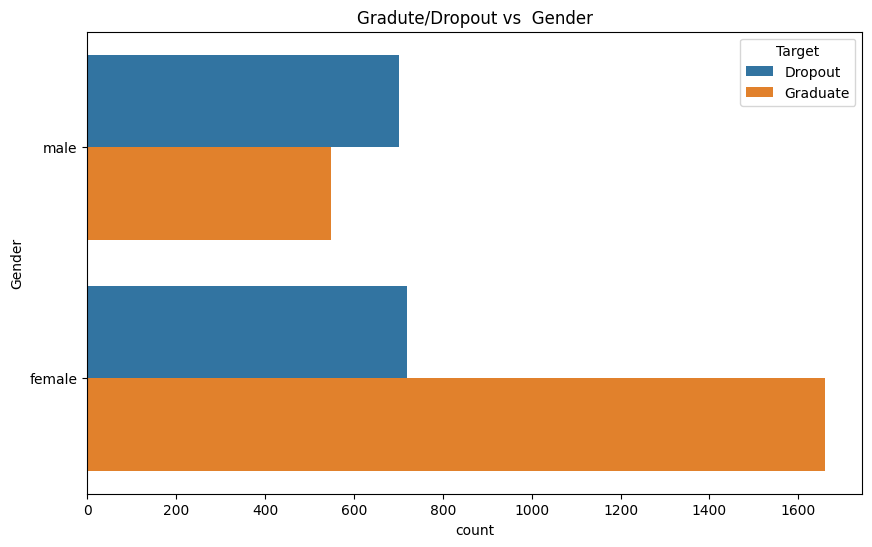

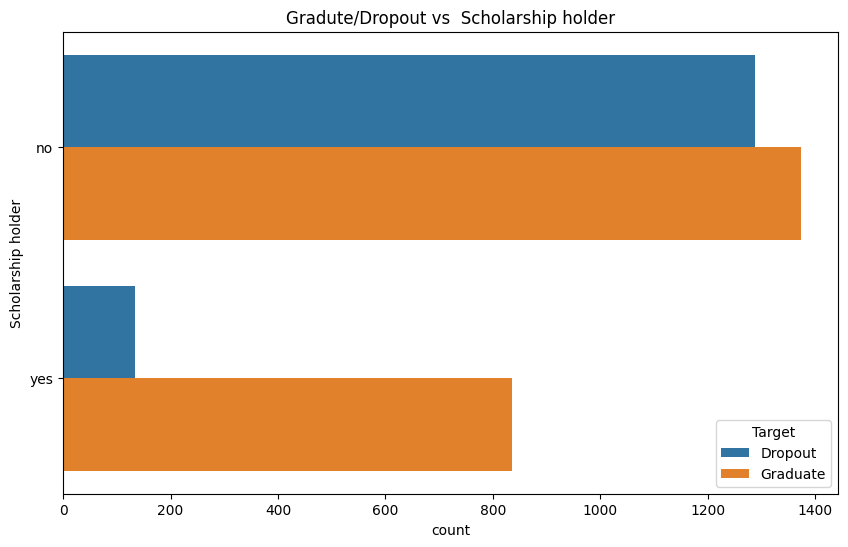

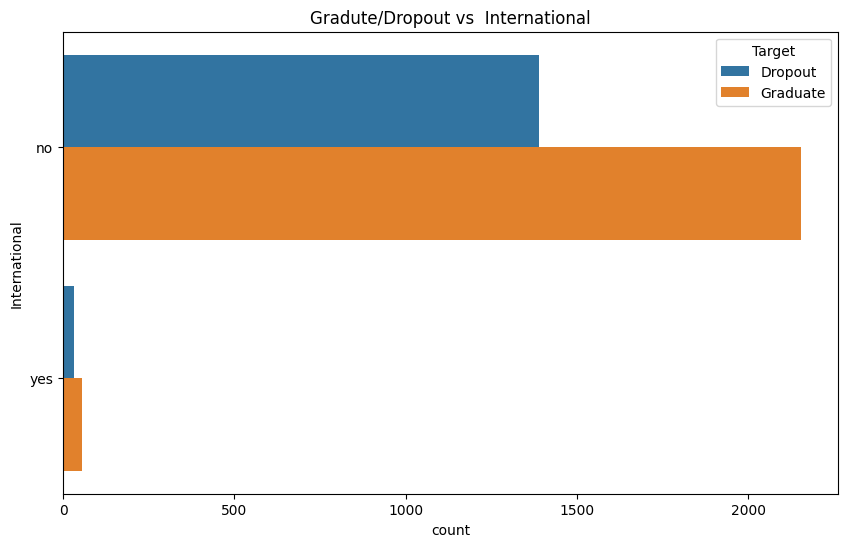

In [12]:
import pylab

# List of categorical features
categorical_features = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance\t',
                        'Previous qualification', 'Mother\'s qualification',
                        'Father\'s qualification', 'Mother\'s occupation', 'Father\'s occupation',
                        'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
                        'Gender', 'Scholarship holder', 'International']


for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(df_withnames, y=feature, hue="Target")
    plt.title('Gradute/Dropout vs  ' + feature)
    plt.show()

In [13]:
df_nationality = df['Nationality'].replace(country_code_dict)
df_nationality = df_nationality.to_frame()
df_nationality['Continent'] = df_nationality['Nationality'].map(country_to_continent)

# df_nationality


In [14]:
print(df_nationality.groupby('Continent')['Nationality'].value_counts())
print(df['International'].value_counts())


Continent      Nationality          
Africa         Cape Verde                 12
               Sao Tome and Principe       9
               Guinea                      5
               Angola                      1
               Mozambique                  1
Europe         Portugal                 3544
               Spain                       8
               Italy                       3
               Ukraine                     3
               Germany                     2
               Moldova                     2
               Lithuania                   1
               Netherlands                 1
               Romania                     1
               Russia                      1
               United Kingdom              1
North America  Mexico                      2
South America  Brazil                     32
               Colombia                    1
Name: Nationality, dtype: int64
0    3544
1      86
Name: International, dtype: int64


In [15]:
import plotly.express as px

# Create a DataFrame with the count of each nationality
df_international = df_nationality[df_nationality['Nationality'] != "Portugal"]
df_counts = df_international['Nationality'].value_counts().reset_index()
df_counts.columns = ['Nationality', 'Count']

# Create the map chart
fig = px.choropleth(df_counts,
                    locations='Nationality',
                    locationmode='country names',
                    color='Count',
                    title='Distribution of International Students',
                    scope='world')




fig.show()


## Model Creation

### Defining our target and features

In [16]:
# We need to label encode our target
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y = labelencoder.fit_transform(df_withnames['Target'])

In [17]:
# One-Hot encoding
# df_withnames.shape
X = pd.get_dummies(df_withnames.iloc[:, 0:36],drop_first=True)
display(X)

,Previous qualification (grade),Nationality,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),...,Father's occupation_Unskilled Industry & Construction Workers,Father's occupation_Unskilled Workers,Father's occupation_Vehicle Drivers,Displaced_yes,Educational special needs_yes,Debtor_yes,Tuition fees up to date_yes,Gender_male,Scholarship holder_yes,International_yes
0,122.0,1,127.3,20,0,0,0,0,0.000000,0,...,0,1,0,1,0,0,1,1,0,0
1,160.0,1,142.5,19,0,6,6,6,14.000000,0,...,0,0,0,1,0,0,0,1,0,0
2,122.0,1,124.8,19,0,6,0,0,0.000000,0,...,0,1,0,1,0,0,0,1,0,0
3,122.0,1,119.6,20,0,6,8,6,13.428571,0,...,0,0,0,1,0,0,1,0,0,0
4,100.0,1,141.5,45,0,6,9,5,12.333333,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,125.0,1,122.2,19,0,6,7,5,13.600000,0,...,0,0,0,0,0,0,1,1,0,0
4420,120.0,105,119.0,18,0,6,6,6,12.000000,0,...,0,1,0,1,0,1,0,0,0,1
4421,154.0,1,149.5,30,0,7,8,7,14.912500,0,...,0,1,0,1,0,0,1,0,1,0
4422,180.0,1,153.8,20,0,5,5,5,13.800000,0,...,0,0,0,1,0,0,1,0,1,0


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Creating Pipeline for Tree models with ensemble models


In [19]:
# create pipeline model to perform multiple models and evaluate their performance with k fold cross validation

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline



# Create a pipeline for each model
models = {
    'Base Model': DummyClassifier(strategy='stratified', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state = 0, criterion= "entropy"),
    "Bagging": BaggingClassifier(n_estimators = 10, random_state=0),
    "AdaBoost": AdaBoostClassifier(n_estimators = 10, random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators = 10, random_state=0),
}


# Loop through each model in the pipeline

scoring = ['accuracy', 'precision', 'recall', 'roc_auc']
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Initialize results storage
results = {}

for name, model in models.items():
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    results[name] = {
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'Precision': np.mean(cv_results['test_precision']),
        'Recall': np.mean(cv_results['test_recall']),
        'ROC AUC': np.mean(cv_results['test_roc_auc']),
    }

# Convert results to DataFrame for display
results_df = pd.DataFrame(results).transpose()

print(results_df)


               Accuracy  Precision    Recall   ROC AUC
Base Model     0.534435   0.618122  0.616030  0.512182
Decision Tree  0.858953   0.888445  0.878265  0.853800
Bagging        0.900275   0.906408  0.932605  0.939995
AdaBoost       0.896143   0.889886  0.946444  0.939034
Random Forest  0.895317   0.901352  0.930347  0.939411


Based on the scores above we choose to proceed with Random Forest model

#### Grid search for hyperparametere optimization

In [20]:
# upload the pickle file (.pkl) to the files for the code to work
grid_pckl_path = '/content/drive/My Drive/CIS_412_Team18_Project/grid_search.pkl'

import os
import pickle
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': range(10, 300, 10),
    'max_depth': range(1, 200, 5)
}

# Create a random forest classifier
rfc = RandomForestClassifier(random_state=0)

# Check if the pickle file exists
if os.path.exists(grid_pckl_path):
    # Load the grid search object
    with open(grid_pckl_path, 'rb') as f:
        grid_search = pickle.load(f)
else:
    # Create the grid search object
    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

    # Fit the grid search
    grid_search.fit(X, y)

    # Save the grid search object
    with open(grid_pckl_path, 'wb') as f:
        pickle.dump(grid_search, f)

# Get the best parameters and
best_params = grid_search.best_params_
grid_search.best_estimator_

RandomForestClassifier(max_depth=46, n_estimators=180, random_state=0)

The grid search is used for hyperparameter optimization for our random forest classifier. In our case hyperparameters are the dept and max estimator which are the number of trees we build in our model. We used cross validation which splits data into folds which gives better results from train test split. We then get the optimized parameters to train our model. Pickel package is used to save the grid_search object since it take long time to run the code with grid search.

In [21]:
feature_names = X.columns
# Train the classifier with the best parameters
rfc_best = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=0)
rfc_best.fit(X_train, y_train)

# Now you can get the feature importances from rfc_best
importances_best = rfc_best.feature_importances_

# Create a DataFrame with feature names and their importance
feature_importances_df_best = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_best
})

# Sort the DataFrame by importance
feature_importances_df_best = feature_importances_df_best.sort_values('Importance', ascending=False)

display(feature_importances_df_best)

,Feature,Importance
13,Curricular units 2nd sem (approved),1.516633e-01
7,Curricular units 1st sem (approved),1.275719e-01
14,Curricular units 2nd sem (grade),1.026936e-01
8,Curricular units 1st sem (grade),8.007602e-02
207,Tuition fees up to date_yes,4.487598e-02
12,Curricular units 2nd sem (evaluations),3.232067e-02
3,Age at enrollment,3.197259e-02
6,Curricular units 1st sem (evaluations),2.804277e-02
2,Admission grade,2.623216e-02
0,Previous qualification (grade),2.333776e-02


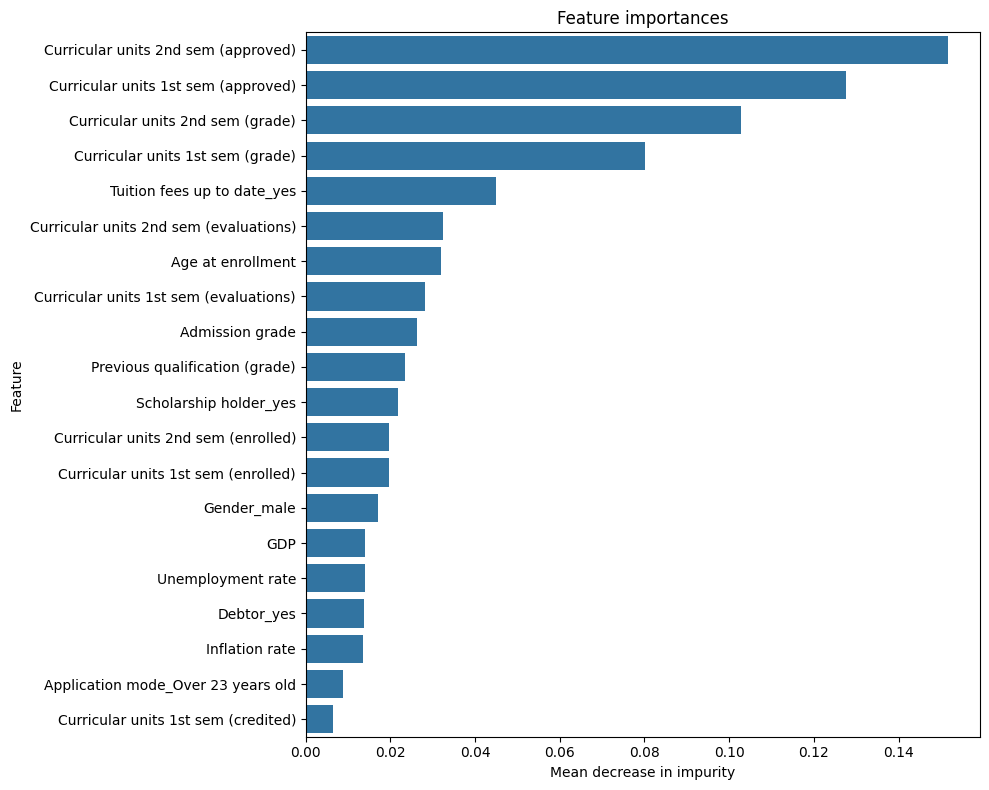

In [22]:
top_20 = feature_importances_df_best.nlargest(20, 'Importance')

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20, orient='h')
plt.title("Feature importances")
plt.xlabel("Mean decrease in impurity")
plt.tight_layout()

           Random Forest
Accuracy        0.907713
Precision       0.894272
Recall          0.962429
ROC AUC         0.952425


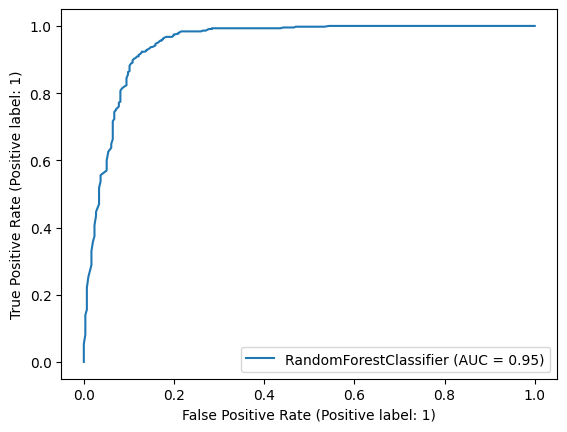

In [23]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score

scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

cv_result = cross_validate(rfc_best, X, y, cv=10, scoring=scoring)

# Initialize results storage
results = {
    'Accuracy': np.mean(cv_result['test_accuracy']),
    'Precision': np.mean(cv_result['test_precision']),
    'Recall': np.mean(cv_result['test_recall']),
    'ROC AUC': np.mean(cv_result['test_roc_auc']),
}

# Convert results to DataFrame for display
results_df = pd.DataFrame(results, index=["Random Forest"]).transpose()

print(results_df)

RocCurveDisplay.from_estimator(rfc_best, X_test, y_test)

### Logistic Regression with L1 and L2 regularization

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Create a pipeline
Logisticregression_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Create space of candidate regularization hyperparameters
C = np.logspace(-4, 4, 50)

# Create a hyperparameter grid
param_grid = {
    'classifier__penalty': ['l2'],
    'classifier__C': C,
    'classifier__solver': ['newton-cg','liblinear', 'sag', 'saga']
    }

grid_pckl_path = '/content/drive/My Drive/CIS_412_Team18_Project/logistic_pckl'

if os.path.exists(grid_pckl_path):
    # Load the model from the file
    with open(grid_pckl_path, 'rb') as f:
        best_model = pickle.load(f)
else:
    # Create a grid search object
    logistic_grid = GridSearchCV(Logisticregression_pipe, param_grid = param_grid, cv = 5,scoring='roc_auc')
    # Fit the grid search
    best_model = logistic_grid.fit(X_train, y_train)
    # Save it into pickle object file
    with open('logistic_pckl', 'wb') as f:
        pickle.dump(best_model, f)


# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['classifier__penalty'])
print('Best C:', best_model.best_estimator_.get_params()['classifier__C'])
print('Best Solver:', best_model.best_estimator_.get_params()['classifier__solver'])

Best Penalty: l2
Best C: 0.02811768697974228
Best Solver: liblinear


In [25]:
# Perform cross validation (holdout test, cv=5 took too long)
scores = cross_val_score(best_model, X, y, cv=2, scoring='roc_auc')

# Print cross validation scores
print('Cross validation scores:', scores)
average_score = np.mean(scores)
print('Average cross validation score:', average_score)

Cross validation scores: [0.94579741 0.93890765]
Average cross validation score: 0.9423525306363914


In [35]:
feature_names = X.columns

# Get the coefficients of the best model
coefficients = best_model.best_estimator_.named_steps['classifier'].coef_[0]

# Create a DataFrame with the coefficients and feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# Reorder the coefficients in descending order
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print(coef_df)

# Save coef_df to a CSV file
coef_df.to_csv('coef_df.csv', index=False)

                                               Feature  Coefficient
13                 Curricular units 2nd sem (approved)     1.419034
7                  Curricular units 1st sem (approved)     0.896056
207                        Tuition fees up to date_yes     0.677649
14                    Curricular units 2nd sem (grade)     0.612218
42              Course_Animation and Multimedia Design     0.398055
8                     Curricular units 1st sem (grade)     0.335465
209                             Scholarship holder_yes     0.322451
53                               Course_Social Service     0.193895
54          Course_Social Service (evening attendance)     0.141709
210                                  International_yes     0.140657
32   Application mode_International student (bachelor)     0.134045
41                                     Course_Agronomy     0.107567
56                           Course_Veterinary Nursing     0.097461
9       Curricular units 1st sem (without evalua

### Neural Networks


#### Using MLPClassifier

In [27]:
from sklearn.neural_network import MLPClassifier
nnet = MLPClassifier(hidden_layer_sizes=(64,32), random_state=0,max_iter= 2000)
nnet.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=2000, random_state=0)

In [28]:
y_pred_MLP = nnet.predict(X_test)
roc_auc_score(y_test, y_pred_MLP, average="weighted")

0.880656819610308

#### Using Custom FNN

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping # To stop model when it stops improving

# Custom Model with 2 hidden layers and 1 ouput layer
def build_fnn(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (dropout or not)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["AUC"])
    return model

input_dim = X_train.shape[1]
fnn_model = build_fnn(input_dim)

# Train the FNN
fnn_model.fit(X_train, y_train, epochs=20, batch_size=32,
                            validation_data=(X_test, y_test),
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])


Epoch 1/20
91/91 [==============================] - 2s 7ms/step - loss: 1.0410 - auc: 0.7199 - val_loss: 0.4040 - val_auc: 0.8978
Epoch 2/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3508 - auc: 0.9180 - val_loss: 0.4301 - val_auc: 0.9204
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 0.3218 - auc: 0.9285 - val_loss: 0.3265 - val_auc: 0.9273
Epoch 4/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2841 - auc: 0.9434 - val_loss: 0.3201 - val_auc: 0.9369
Epoch 5/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2749 - auc: 0.9444 - val_loss: 0.3180 - val_auc: 0.9410
Epoch 6/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2666 - auc: 0.9472 - val_loss: 0.2978 - val_auc: 0.9419
Epoch 7/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2543 - auc: 0.9509 - val_loss: 0.3892 - val_auc: 0.9443
Epoch 8/20
91/91 [==============================] - 0s 3ms/step - loss: 0.2581 - auc: 0.95

In [30]:
y_pred_fnn = fnn_model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_fnn)
print(f"AUC Score: {auc_score}")

23/23 [==============================] - 0s 1ms/step
AUC Score: 0.954588309239472


## Converting the .ipynb file

In [31]:
# install latex for converting .ipynb to pdf
!apt-get install texlive-xetex

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-ja

In [32]:
# Turn jupyter notebook into pdf and html.
# <------  First you need to upload the .ipynb file to the files
%%shell
# jupyter nbconvert --to html /content/project.ipynb
# jupyter nbconvert --to pdf /content/project.ipynb